### Dataset link: https://www.kaggle.com/kmader/finding-lungs-in-ct-data/data

In [1]:
# Import libraries

import os
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.transform import resize
from skimage.segmentation import mark_boundaries, find_boundaries
from skimage import io
import tifffile as tiff
import numpy as np
from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage.morphology import binary_erosion, binary_fill_holes
import nibabel as nib
import glob

ROOT_DIR = os.path.abspath("../")
DATASET_NAME = "Lung-Segmentation"
DATASET_PATH = os.path.join(ROOT_DIR, "datasets", DATASET_NAME)
print(os.listdir(DATASET_PATH))

['2d_masks.zip', '2d_images', 'lung_stats.csv', '3d_images', '2d_masks', '3d_images.zip', '2d_images.zip']


In [2]:
# From https://github.com/rezazad68/BCDU-Net/blob/master/Lung%20Segmentation/Reza_functions.py
def hu_to_grayscale(volume):
    volume = np.clip(volume, -512, 512)
    mxval  = np.max(volume)
    mnval  = np.min(volume)
    im_volume = (volume - mnval)/max(mxval - mnval, 1e-3)
    im_volume = im_volume
    return im_volume *255



def get_mask_alung(vol):
    vol_im = np.where(vol>0, 1, 0)
    shp    = vol.shape
    around_lung = np.zeros((shp[0], shp[1], shp[2]), dtype=np.float32)
    for idx in range(shp[0]):
            around_lung[idx, :, :] = binary_erosion(vol_im[idx], structure=np.ones((15,15))).astype(vol_im.dtype)
            
    return around_lung



def get_mask(segmentation):
    # initialize output to zeros
    shp    = segmentation.shape
    lung = np.zeros((shp[0], shp[1], shp[2]), dtype=np.float32)
   
    # Get mask for kidney and tumor
    lung[np.equal(segmentation,255)] = 255
    
    return lung
    
    
    
def get_FOV(around_lung, lung):
    FOV = np.where((around_lung + lung) >0, 1, 0)
    for idx in range(FOV.shape[0]):
        FOV[idx, :, :] = binary_fill_holes(FOV[idx, :, :], structure=np.ones((5,5))).astype(FOV.dtype)
    return FOV



def return_axials(vol, seg):

    # Prepare segmentation and volume
    vol = vol.get_data()
    seg = seg.get_data()
    seg = seg.astype(np.int32)
    
    # Convert to a visual format
    vol_ims = hu_to_grayscale(vol)
    lung    = get_mask(seg)
    #around_lung = get_mask_alung(vol_ims)
    #FOV = get_FOV(around_lung, lung)
    #around_lung = np.where((FOV - lung) >0, 1, 0)

    return vol_ims, lung #, around_lung, FOV

In [3]:
# Read train data
idx_count =1
train_vol_path = "{}/3d_images/".format(DATASET_PATH) #next(os.walk("{}/3d_images/".format(DATASET_PATH)))[2]
train_vol_files_list = glob.glob(train_vol_path + '/*.gz')
len(train_vol_files_list)

8

In [4]:
# Read train data
idx_count =1
image_path = '{}/2d_images/'.format(DATASET_PATH)
mask_path = '{}/2d_masks/'.format(DATASET_PATH)

images_paths = [os.path.join(image_path, x) for x in os.listdir(image_path)]
mask_paths = [os.path.join(mask_path, x) for x in os.listdir(mask_path)]

len(images_paths),len(mask_paths)

import cv2

# Loads 2D data as numpy arrays of images and masks
images_small_rs = np.empty((len(images_paths), 256, 256), dtype='float32')

for i, name in enumerate(images_paths):
    im = cv2.imread(name, cv2.IMREAD_UNCHANGED).astype("int16").astype('float32')
    im = cv2.resize(im, dsize=(256, 256), interpolation=cv2.INTER_LANCZOS4)
    im = (im - np.min(im)) / (np.max(im) - np.min(im))
    images_small_rs[i] = im

masks_small_rs = np.empty((len(images_paths), 256, 256), dtype='float32')

for i, name in enumerate(mask_paths):
    im = cv2.imread(name, cv2.IMREAD_UNCHANGED).astype('float32')/255.
    im = cv2.resize(im, dsize=(256, 256), interpolation=cv2.INTER_NEAREST)
    masks_small_rs[i] = im
    
    
images_small_rs = images_small_rs[:,:,:,np.newaxis]
masks_small_rs = masks_small_rs[:,:,:,np.newaxis]

images_small_rs.shape, masks_small_rs.shape

((267, 256, 256, 1), (267, 256, 256, 1))

In [5]:
# Define Train data and mask
images_rs   = []
masks_rs   = []

In [6]:
IMG_DIM = (256, 256)


for idx in tqdm(range(len(train_vol_files_list))): 
    
    # Get path
    b = train_vol_files_list[idx]
    
    # Get IMG from path
    a = b[len(train_vol_path):len(train_vol_path)+3]
    if a=='IMG':
        
        print(idx_count)
        
        # Get mask path
        a = b[len(train_vol_path)+4:len(b)]
        mask_path = (train_vol_path+'MASK_' + a)

        # Read volume and mask
        vol = nib.load(train_vol_files_list[idx])
        seg = nib.load(mask_path)
        
        print("Shape of scan: ", vol.shape)
        
        # Get the axials images and corresponding masks
        #vol_ims, lung, around_lung, FOV = return_axials(vol, seg)
        vol_ims, lung = return_axials(vol, seg)
        segmentation  = seg.get_data()
        
       # Insert samples to the Train data, which has the segmentation label
        for idx in range(vol.shape[0]):
            # add if mask exists
            if ~( np.sum(np.sum(np.sum(segmentation[idx, :, :]))) == 0):
                
                # Resize
                img = np.expand_dims(resize(vol_ims [idx, :, :], IMG_DIM), axis=-1)
                mask = resize(lung[idx, :, :], IMG_DIM).round()
                mask[mask > 1] = 1
                mask = np.expand_dims(mask, axis=-1)
                
                images_rs.append(img)
                masks_rs.append(mask)               
        
        idx_count += 1
        
        

images_rs = np.array(images_rs)
masks_rs = np.array(masks_rs)
images_rs.shape, masks_rs.shape

  0%|          | 0/8 [00:00<?, ?it/s]/home/hz/anaconda3/envs/seg/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


1
Shape of scan:  (465, 512, 512)


/home/hz/anaconda3/envs/seg/lib/python3.6/site-packages/ipykernel_launcher.py:47: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/home/hz/anaconda3/envs/seg/lib/python3.6/site-packages/ipykernel_launcher.py:28: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
 12%|█▎        | 1/8 [00:08<00:58,  8.36s/it]

2
Shape of scan:  (325, 512, 512)


 25%|██▌       | 2/8 [00:13<00:37,  6.32s/it]

3
Shape of scan:  (117, 512, 512)


 75%|███████▌  | 6/8 [00:14<00:03,  1.76s/it]

4
Shape of scan:  (301, 512, 512)


100%|██████████| 8/8 [00:19<00:00,  2.40s/it]


((1021, 256, 256, 1), (1021, 256, 256, 1))

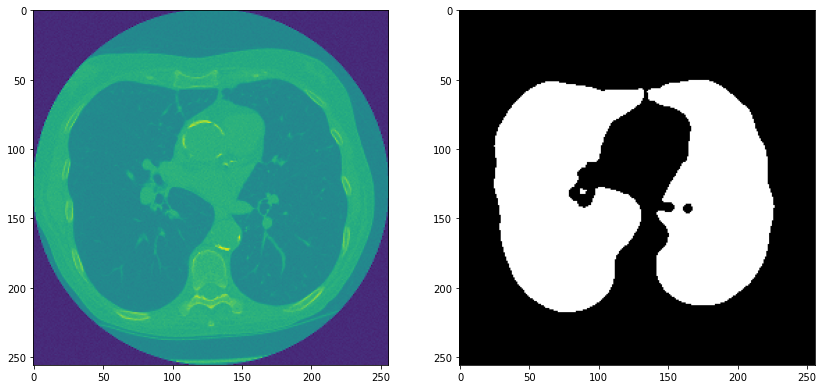

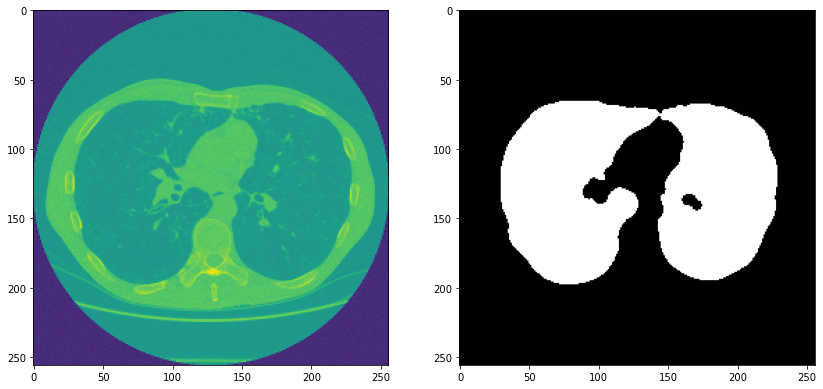

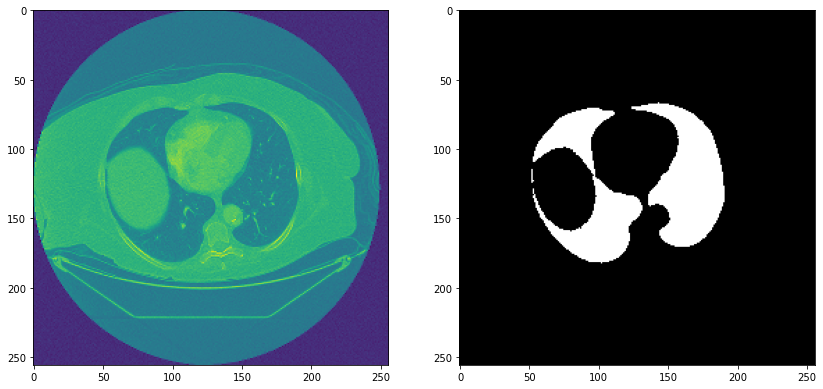

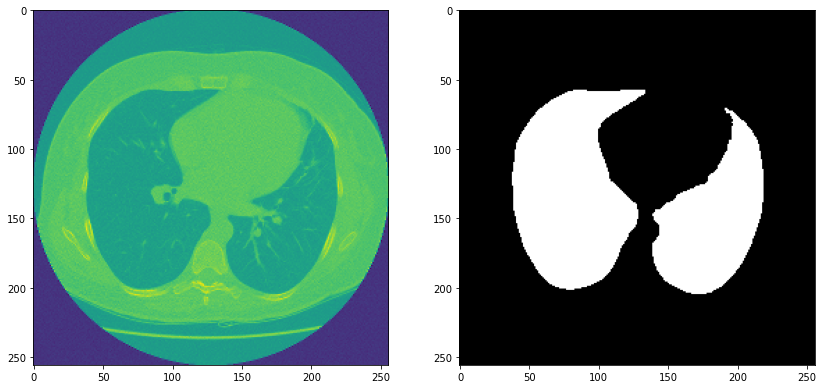

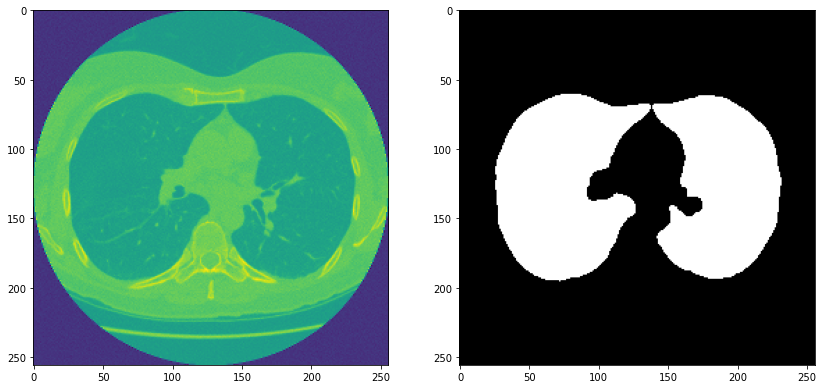

In [7]:
for img, mask in zip(images_small_rs[0:5], masks_small_rs[0:5]):
    
    img = np.squeeze(img, axis=-1) # change to H, W
    mask = np.squeeze(mask, axis=-1) # change to H, W
    
    
    fig,_ = plt.subplots(nrows=1, ncols=2, figsize=(14,12))
    fig.axes[0].imshow(img)
    fig.axes[1].imshow(mask, cmap='gray')
    plt.show()

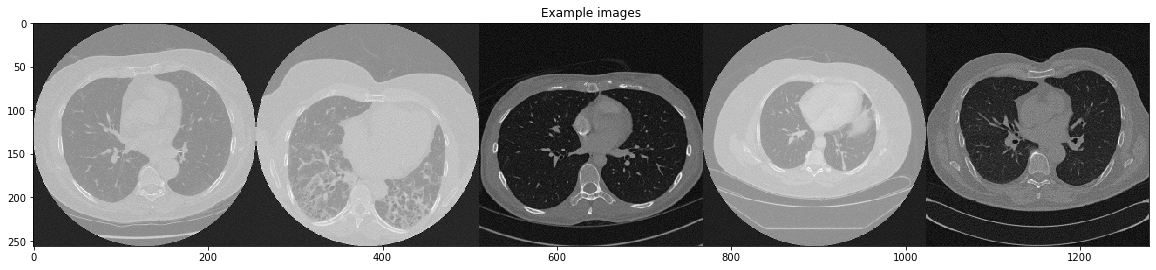

In [8]:
plt.rcParams['figure.figsize'] = (20, 5)
plt.title("Example images")
plt.figsize=(14,12)
plt.imshow(np.concatenate(images_small_rs[130:135].squeeze().transpose((0,1,2)),axis=1), cmap='gray', interpolation='none')

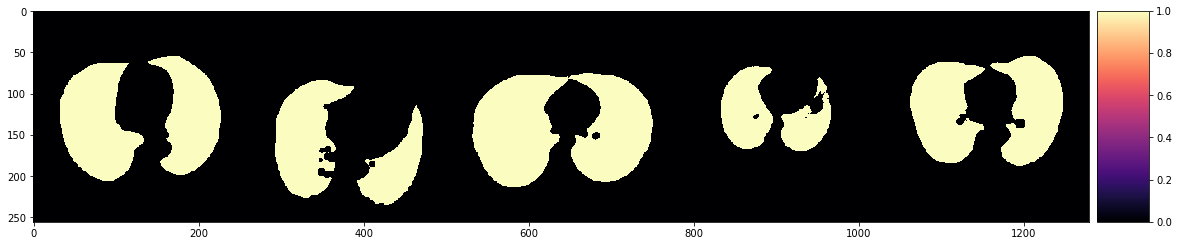

In [9]:
fig = plt.figure(1, figsize=(20, 5))
ax = plt.gca()
im = ax.imshow(np.concatenate(masks_small_rs[130:135,:,:,0],axis=1), cmap='magma', interpolation='none') # cmap='bwr'
divider = make_axes_locatable(ax) 
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)

In [10]:
images_rs.shape, masks_rs.shape

((1021, 256, 256, 1), (1021, 256, 256, 1))

In [11]:
images_small_rs.shape, masks_small_rs.shape

((267, 256, 256, 1), (267, 256, 256, 1))

In [12]:
np.save("{}/LUNGS2_images.npy".format(DATASET_PATH), images_small_rs)
np.save("{}/LUNGS2_mask.npy".format(DATASET_PATH), masks_small_rs)

In [13]:
np.save("{}/LUNGS_images.npy".format(DATASET_PATH), images_rs)
np.save("{}/LUNGS_mask.npy".format(DATASET_PATH), masks_rs)